# Data Loading

In [29]:
# Loading required packages 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [30]:
# Loading data from NFP_AGENCY_TRAIN and NFP_NURSE_INFO_TRAIN sheets
agency = pd.read_csv("NFP_AGENCY_TEST.csv")
nurse=pd.read_csv("NFP_NURSE_INFO_TEST.csv")
nurse.info()
agency.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5589 entries, 0 to 5588
Data columns (total 9 columns):
nurse_id              5589 non-null int64
month                 5589 non-null int64
site_id               5589 non-null int64
first_visit_dt        5589 non-null object
fte                   5582 non-null float64
term_flag             685 non-null float64
nurse_primary_role    5589 non-null object
numcases_actual       5543 non-null float64
numcases_assigned     5477 non-null float64
dtypes: float64(4), int64(3), object(2)
memory usage: 393.1+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 198 entries, 0 to 197
Data columns (total 12 columns):
state                    198 non-null object
site_id                  198 non-null int64
referral_count           196 non-null float64
conversion_rate          196 non-null float64
percent_retained_preg    198 non-null float64
percent_retained_1yr     193 non-null float64
percent_retained_2yr     189 non-null float64
first_hv           

# L-Score calculation

For a nurse, L-Score = Actual cases - Assigned cases

In [31]:
# Subsetting only required fields for calculation
nurse_ls = nurse[['site_id','numcases_actual','numcases_assigned']]
nurse_ls.dropna()
nurse_ls.info()

# Adding column to calculate L-Scores
nurse_ls=nurse.copy()
nurse_ls['l_score'] = nurse_ls['numcases_actual'] - nurse_ls['numcases_assigned']
nurse_ls['l_score'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5589 entries, 0 to 5588
Data columns (total 3 columns):
site_id              5589 non-null int64
numcases_actual      5543 non-null float64
numcases_assigned    5477 non-null float64
dtypes: float64(2), int64(1)
memory usage: 131.1 KB


count    5431.000000
mean       -0.014546
std         0.766212
min       -10.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        10.000000
Name: l_score, dtype: float64

In [32]:
# Grouping L-Scores by site and storing into a Dataframe.
l_scores = nurse_ls.groupby('site_id')['l_score'].sum().sort_values()
l_scores=pd.DataFrame(l_scores, columns = ['l_score'])
l_scores.head(5)

,l_score
site_id,
178,-15.0
349,-11.0
141,-10.0
217,-9.0
187,-9.0


In [33]:
# Merging L-Scores with agency dataframe.
agency=pd.merge(agency,l_scores, on='site_id')

agency.describe()

,site_id,referral_count,conversion_rate,percent_retained_preg,percent_retained_1yr,percent_retained_2yr,pct_urban,num_clients,s_meetings,l_score
count,198.000000,196.000000,196.000000,198.000000,193.000000,189.000000,197.000000,198.000000,195.000000,198.000000
mean,232.247475,283.035714,39.455816,84.921061,49.482176,30.090370,72.971523,998.287879,227.020513,-0.398990
std,92.006204,285.918302,16.553566,9.728814,13.787533,14.814805,29.171067,917.805368,168.015861,5.660209
min,86.000000,19.000000,6.980000,0.000000,0.000000,0.000000,0.000000,87.000000,1.000000,-15.000000
25%,153.250000,120.000000,28.115000,81.107500,42.110000,19.720000,53.850000,384.750000,126.000000,0.000000
50%,218.500000,198.000000,39.135000,85.475000,50.600000,29.850000,86.360000,807.000000,189.000000,0.000000
75%,314.750000,328.500000,48.355000,90.910000,57.320000,38.360000,96.700000,1188.750000,282.500000,0.000000
max,414.000000,1949.000000,100.000000,100.000000,94.440000,100.000000,100.000000,5908.000000,1085.000000,70.000000


# Analysis of features

On plotting average number of clients (num_clients) vs L-Scores, it is observed that for L-Scores close to the ideal score of 0, the average number of clients is low.

The urbanicity % (pct_urban) is found to be mostly high for ideal score. L-Score = 65.16% of agencies have L-Score = 0 and urbanicity percentage>60%.

0.7013888888888888

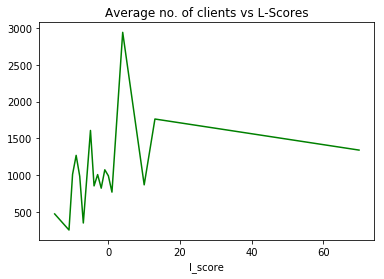

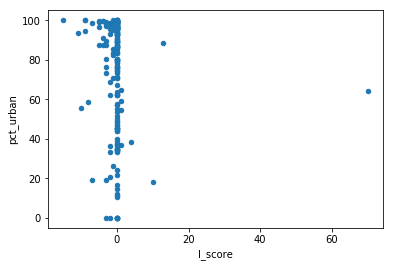

In [34]:
# Plotting Average No. of clients vs L-Scores
agency.groupby('l_score')['num_clients'].mean().plot(title='Average no. of clients vs L-Scores', x='L-Score', color='green')
agency.plot('l_score', 'pct_urban', kind='scatter')

# Plotting Urbanicity % vs L-Scores
agency.site_id[(agency.pct_urban>60) & (agency.l_score==0)].count()/agency.site_id[agency.l_score==0].count()

# Logistic Regression

We will now proceed to implement logistic regression using pct_urban and num_clients as features. Since most values for L-score are either 0 or negative, we will consider L-Score as outcome variable with binary output L-Score between 0 and -5 (Output 1) and L-Score less than -5  (Output 0). 

In [27]:
# Retaining only negative and zero L-Scores
agency_n = agency[agency.l_score<=0]

# Mapping to target values 0 and 1
agency_n.loc[agency_n['l_score'] >= -5, 'l_score'] = 0
agency_n.loc[agency_n['l_score'] < -5, 'l_score'] = 1

/Users/snehanair/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [28]:
# Split dataset in features and target variable
agency_n=agency_n[['pct_urban','num_clients','l_score']]
agency_n=agency_n.dropna()
X = agency_n[['pct_urban','num_clients']] # Features
X = X.reset_index()
y = agency_n.l_score # Target variable
agency_n.shape

# We have 207 sites after dropping records with NaN values.

(189, 3)

In [5]:
# Feature scaling for pct_urban and num_clients
from sklearn import preprocessing
std_scale = preprocessing.StandardScaler().fit(X[['pct_urban', 'num_clients']])
X = std_scale.transform(X[['pct_urban', 'num_clients']])

NameError: name 'X' is not defined

In [6]:
# Split X and y into training and testing sets in 0.75:0.25 ratio.
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)
X_train.shape

# 155 values in the training set, remaining in test set.

NameError: name 'X' is not defined

In [7]:
# Creating the logistic regression model
logreg = LogisticRegression()

# Fitting the model with data
logreg.fit(X_train,y_train)

# Predicting values on test data
y_pred=logreg.predict(X_test)


NameError: name 'X_train' is not defined

In [99]:
# Plotting the confusion matrix.
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[40,  3],
       [ 8,  1]], dtype=int64)

Text(0.5,257.44,'Predicted label')

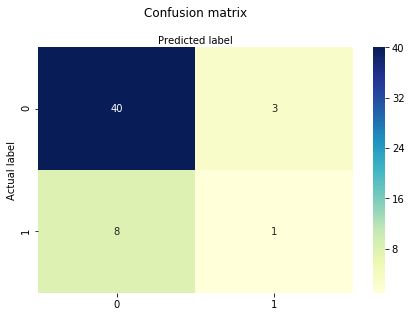

In [100]:
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Plotting of heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [101]:
# Accuracy of model
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.7884615384615384
